# Study transition non-ergotic to ergotic

In this notebook we investigate the transition from non-ergodic to ergodic regimes of the FPU system. Such transition can be better observed on the trajectory obtained with the critical observed non-linear coupling parameter $\beta$=1.6. Indeed, in such trajectory energy equipartition is observed after few superrecurrence cycles.

To study the transition, we train a recurrent-neural network-based autoencoder and use it to investigate the energy exchange across modes as the system evolves in time.

### Non-ergodic phase to ergodic phase transition

The FPU system's nonlinearity can cause the initial state's energy to be localized in specific modes [], causing the system to being non-ergodic.
Within this phase, non-ergodicity is observed with the presence of invariant tori, often denoted as "q-tori" in the phase space. 
((These tori correspond to energy states where the dynamics are characterized by the presence of a mode with a specific resonance, which is determined by the value of "q".))

[https://arxiv.org/pdf/1205.2573.pdf]

As the FPU system evolves, nonlinear interactions between modes results in energy moving from one mode to another. This process leads to the system transitioning from a non-ergodic phase to an ergodic phase.

Transitioning into the ergodic phase, the system becomes cahotic i.e. samples various possible configurations and energy distributions. In this phase, the system's behavior becomes predictable based on statistical averages.

### Using Autoencoder model to detect phase transition 

We use a Long Short-Term Memory (LSTM)-based autoencoder to to investigate the energy exchange across modes as the system evolves in time. <br>
First, we train the autoencoder model on a portion of the trajectory data that corresponds to the non-ergotic phase. This is done optimising the model's parameters with respect to a mean square error (MSE) loss.

Arguably, the autoencoder will learn a compressed manifold representation of the system dynamics, which accounts also for energy transfers across q-invariant tori. Hence, the trained autoencoder will be able to reconstruct any input that contains trajectory data snapshots taken within the non-ergotic phase with low reconstruction error (MSE).

As the system evolves, and transitions into the non-ergotic phase, the loss of stability of the resonant energy states causes breaking of q-invariant tori. Hence the reconstruction error of the autoencoder becomes progressively larger.

The reconstruction error shall be compared with the energy exchange patterns between different modes of the system.


## Steps

The steps are:

1. Dataset Preparation: 

We accurately chose a portion of the initial dataset data points (up to n_portion = 800000), that describe the dynamics of the system for times long enough so that a few recurrences in the energy plots are observed for low $\beta$. This is characteristic of the FPU that we are investigating.

To prepare the data for training a LSTM neural network so that it can effectively work, we transformed the original trajectories into short sequences that preserves the sequential order. For that, we used a sliding window approach defined in `src.utils.temporalize_data`.

2. Train autoencoder:

The autoencoder model is trained with Adam optimiser, using the mean squared error (MSE) as loss function to minimize reconstruction error.


3. Sensitivity Analysis:

In this step, we investigate how the energy transfer across modes manifests itself as trajectories move in the latent space (and compare with q-invariant tori):

After training, the reconstruction error is measured for different snapshots along the trajectory data.
As the system evolves into the ergotic phase, the latent space representations is perturbed and this can be observed with increase of the reconstruction error.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt 

import sys
sys.path.append('../')

from src.utils import load_data

DATA_DIR = '../data'
BETA_VALUES = np.sort(
    [float(x.split('fermi_')[-1]) for x in os.listdir(DATA_DIR) if x.startswith('fermi')])

print('Beta values:',len(BETA_VALUES))

Beta values: 30


## 1. Dataset Preparation: 

In [2]:
from src.utils import temporalize_data

data_train = load_data(DATA_DIR, 0.5)

timesteps = 5
n_portion = 800000

X_train_portion = data_train.data_matrix[:n_portion] 
X_train = temporalize_data(X_train_portion, timesteps)

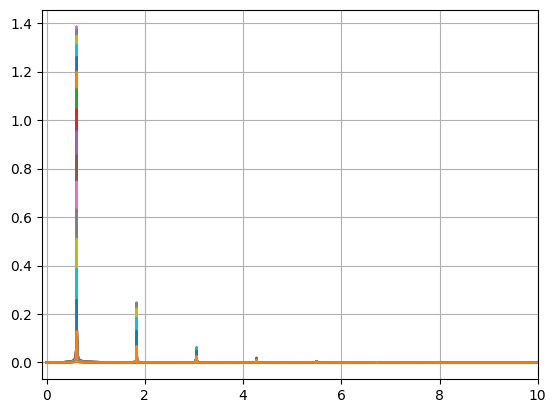

In [115]:
## find q tori
from scipy.fft import fft, fftfreq

q = X_train_portion[:, :32]

#  FFT trajectory
T = 1.0 / 800.0
for particle_idx in range(q.shape[-1]):
    q_ = q[:, particle_idx]

    yf = fft(q_)
    N = len(q_)
    xf = fftfreq(N, T)[:N//2]

    y = 2.0/N * np.abs(yf[0:N//2])

    plt.plot(xf, y, label='1')
    # plt.plot(2.0/N * np.abs(yf[0:N//2]), label='1')
    # plt.plot(yf)
    # plt.xlim(-100, 10000)
    plt.xlim(-1, 20)
    
    
plt.xlim(-0.1, 10)
plt.grid()

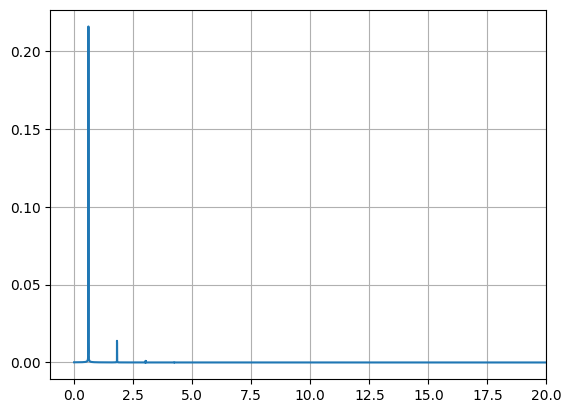

In [111]:
q_ = q[:, 0]

yf = fft(q_)
N = len(q_)
xf = fftfreq(N, T)[:N//2]

y = 2.0/N * np.abs(yf[0:N//2])

plt.plot(xf, y, label='1')
# plt.plot(2.0/N * np.abs(yf[0:N//2]), label='1')
# plt.plot(yf)
# plt.xlim(-100, 10000)
plt.xlim(-1, 20)
plt.grid()

In [89]:
def find_peak_indices_with_threshold(arr, threshold):
    peak_indices = np.where((arr > threshold) & (arr > np.roll(arr, 1)) & (arr > np.roll(arr, -1)))[0]
    return peak_indices

peaks_idx = find_peak_indices_with_threshold(y, 0.02)

# plt.plot(xf, y)
# plt.xlim(-0.1, 10)


peaks_idx

array([ 608,  617,  625, 1842, 1850, 1868, 1876, 3093, 3101, 3118, 3127,
       4378])

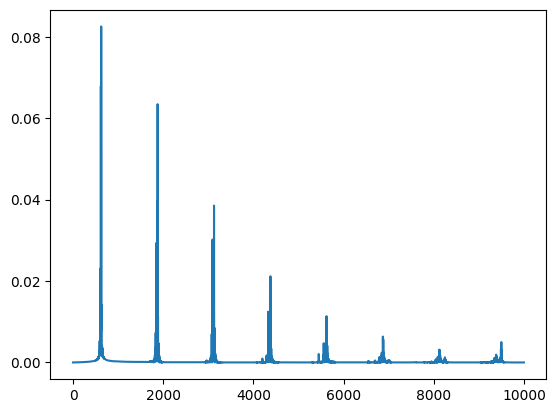

In [98]:
y_ = y[:10000]

plt.plot(y_)

In [105]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=8, random_state=0).fit(y_.reshape(-1, 1))

# Get cluster labels
labels = kmeans.labels_

# Find the cluster with the higher mean value (peak cluster)
peak_cluster = np.argmax(kmeans.cluster_centers_)

# Find indices of data points belonging to the peak cluster
peak_indices = np.where(labels == peak_cluster)[0]


print("Peak indices:", peak_indices)

Peak indices: [625 626]


/Users/alessandro.romualdi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [106]:
y_[peak_indices]

array([0.08251166, 0.07607459])

In [108]:
peak_cluster

7

## 2. Train autoencoder

Train LSTM autoencoder on first portion of trajectory data, when no equipartition is observed

In [5]:
from src.models import autoencoder_model

model = autoencoder_model(timesteps)
model.fit(X_train, X_train, epochs=3, batch_size=64, verbose=True)

Epoch 1/3
12500/12500 [==============================] - 43s 3ms/step - loss: 0.0052
Epoch 2/3
12500/12500 [==============================] - 40s 3ms/step - loss: 6.7069e-04
Epoch 3/3
12500/12500 [==============================] - 42s 3ms/step - loss: 4.4849e-04


In [4]:
import pickle

# pickle.dump(model, open("output/04_transition_to_equipartition/model.pkl", "wb" ) )
# model = pickle.load( open("output/04_transition_to_equipartition/model.pkl", "rb" ) )

AttributeError: 'Adam' object has no attribute 'build'

In [6]:
# use encoder to encode input trajectory data onto low-dimensional space
from keras.models import Model

encoder_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
X_train_enc = encoder_model.predict(X_train)

25000/25000 [==============================] - 12s 484us/step


In [7]:
# compute max reconstruction error on train set (times range within which no equipartition observed, so still in the toroid manifold)

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

thresholds_train = []
for feature_idx in range(train_mae_loss.shape[1]):
    # feature_threshold = np.mean(train_mae_loss[:,feature_idx]) + np.std(train_mae_loss[:,feature_idx])
    feature_threshold = np.max(train_mae_loss[:, feature_idx])
    thresholds_train.append(feature_threshold)

max_thresholds_train = max(thresholds_train)

idx_feature_max_err = (np.argmax(thresholds_train))

print(f'Max threshold erorr train: {np.round(max_thresholds_train, 3)}, found at trajectory feature {idx_feature_max_err}')

25000/25000 [==============================] - 19s 745us/step
Max threshold erorr train: 0.199, found at trajectory feature 47


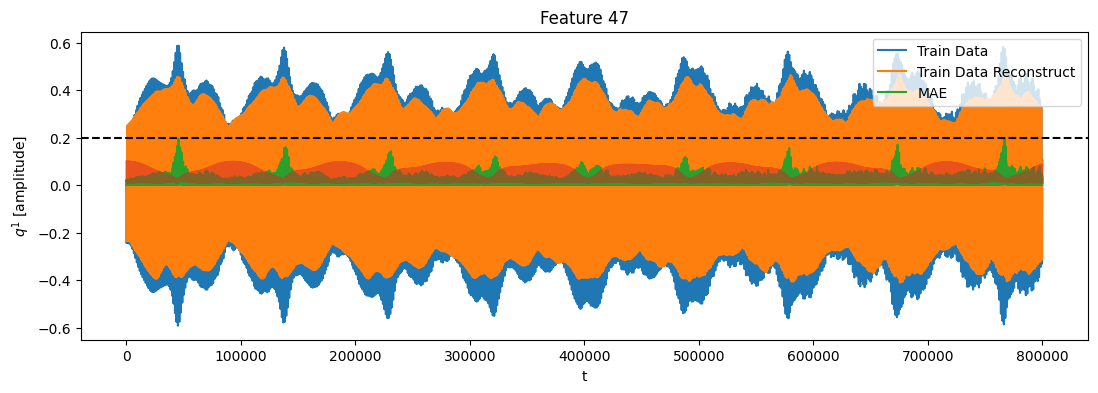

In [9]:
# visualise reconstruction error train. Note I visualise for a specific feature, being the one for which error is max

plt.figure(figsize=(13, 4))

limit = 1000000

plt.plot(X_train[:limit, 0, idx_feature_max_err], label='Train Data')
plt.plot(X_train_pred[:limit,0,idx_feature_max_err], label='Train Data Reconstruct')
plt.plot(train_mae_loss[:limit, idx_feature_max_err], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

plt.plot(distances_train[:limit] / 100, alpha=0.5)

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.title(f"Feature {idx_feature_max_err}")
plt.show()

In [242]:
# #  FFT trajectory

# from scipy.fft import fft, fftfreq

# T = 1.0 / 800.0

# X_enc_ = X_train_portion[:, 0]

# yf = fft(X_enc_)
# N = len(X_enc_)
# xf = fftfreq(N, T)[:N//2]

# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label='1')
# # plt.plot(2.0/N * np.abs(yf[0:N//2]), label='1')
# # plt.plot(yf)
# # plt.xlim(-100, 10000)
# plt.xlim(-1, 20)

### FFt in latent space

In [10]:
encoder_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

X_enc = encoder_model.predict(X_train)

25000/25000 [==============================] - 12s 461us/step


(-1.0, 10.0)

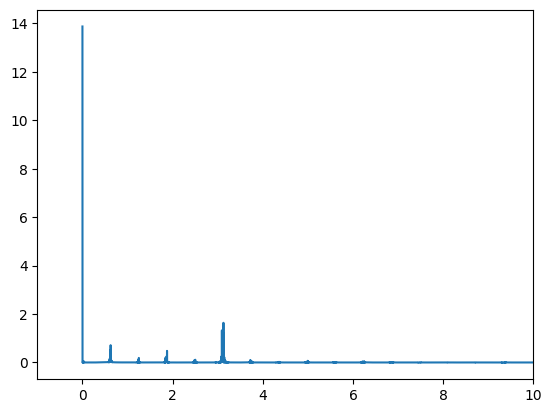

In [11]:
from scipy.fft import fft, fftfreq

T = 1.0 / 800.0

X_enc_ = X_enc[:, 0] #[:100000]

yf = fft(X_enc_)
N = len(X_enc_)
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label='1')
# plt.plot(2.0/N * np.abs(yf[0:N//2]), label='1')
# plt.plot(yf)
# plt.xlim(-100, 10000)
plt.xlim(-1, 10)

## Find phase transition

In [12]:
# Test on remaining portion, where at some point equipartition is observed

data_test = load_data(DATA_DIR, 1.6)
time_test = data_test.time

X_test_portion = data_test.data_matrix[-300000:-1] 
energy_test = data_test.energy_matrix[-300000 +6:-1]  # to account for temporalisation
time_test = time_test[-300000 +6:-1]  # to account for temporalisation
distances_test = data_test.dst[-300000:-1]

X_test = temporalize_data(X_test_portion, 5)

X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

time_test.shape, X_test_portion.shape, distances_test.shape

9375/9375 [==============================] - 7s 724us/step


((299993,), (299999, 64), (299999,))

#### FFT in latent space

In [13]:
encoder_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

X_test_enc = encoder_model.predict(X_test)

9375/9375 [==============================] - 4s 454us/step


(-1.0, 10.0)

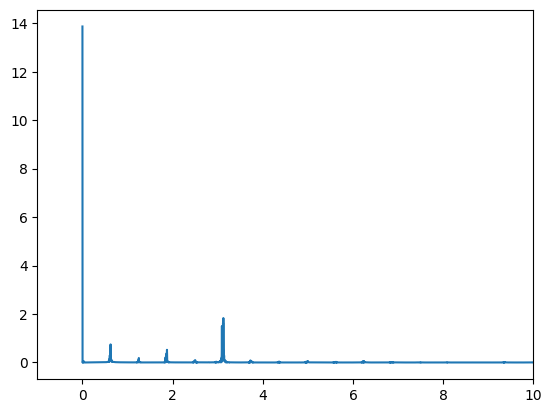

In [14]:
from scipy.fft import fft, fftfreq

T = 1.0 / 800.0

X_test_enc_ = X_test_enc[:, 0] #[:100000]

yf = fft(X_test_enc_)
N = len(X_test_enc_)
xf = fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label='1')
plt.xlim(-1, 10)

In [26]:
X_test_enc.shape

X_test_enc_ = X_test_enc[:8000]

### Evolution

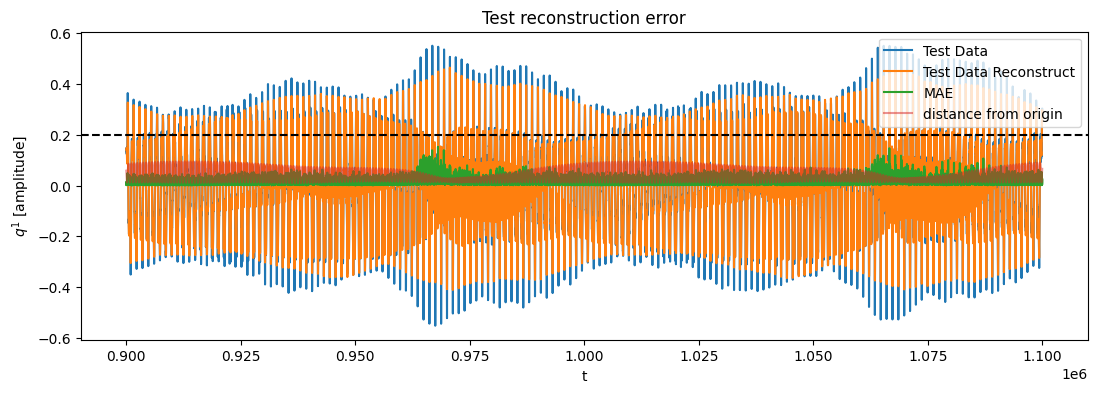

In [27]:
plt.figure(figsize=(13, 4))

limit = 200000

plt.plot(time_test[:limit], X_test[:limit, 0, idx_feature_max_err],label='Test Data')
plt.plot(time_test[:limit], X_test_pred[:limit, 0, idx_feature_max_err],label='Test Data Reconstruct')
plt.plot(time_test[:limit], test_mae_loss[:limit, idx_feature_max_err], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

plt.plot(time_test[:limit], distances_test[:limit] / 100, alpha=0.5, label='distance from origin')

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.title(f'Test reconstruction error')
plt.show()

In [29]:
# find energy portion relative to above threshold reconstruction errror

def find_ranges(nums):

    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    ranges  = list(zip(edges, edges))

    return ranges

times_above_threshold = np.where(test_mae_loss[:limit, idx_feature_max_err] > max_thresholds_train-0.09)[0] + time_test[0]

ranges = find_ranges(times_above_threshold)

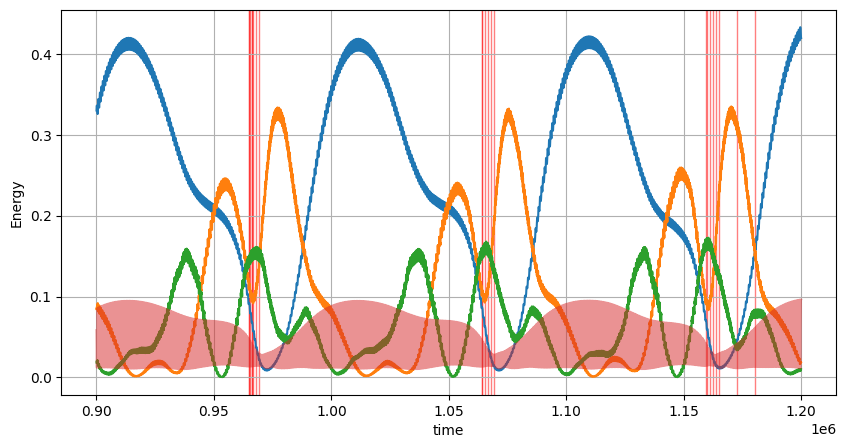

In [30]:
# find energy portion relative to above threshold reconstruction errror

fig, (ax) = plt.subplots(1, 1, figsize=(10,5))
ax.plot(time_test, energy_test[:,0], linewidth=1.5, label="Mode 1") 
ax.plot(time_test, energy_test[:,2], linewidth=1.5, label="Mode 3")
ax.plot(time_test, energy_test[:,4], linewidth=1.5, label="Mode 5")
# ax.scatter(times_above_threshold, [0.0] * len(times_above_threshold), color='red') 

limit = 299993
ax.plot(time_test[:limit], distances_test[:limit] / 100, alpha=0.5)

# ax.axvspan(1182784, 1182798, alpha=0.5, color='red')
for r in ranges:
    ax.axvspan(r[0], r[1], alpha=0.5, color='red')

ax.set_xlabel('time')
ax.set_ylabel('Energy')
ax.grid()

### test on data for higher beta

In [131]:
data_test_beta2 = load_data(DATA_DIR, 2.0)
time_test_beta2 = data_test_beta2.time

X_test_beta2_portion = data_test_beta2.data_matrix[100000:600000] 
energy_test_beta2 = data_test_beta2.energy_matrix[100000:600000]  # to account for temporalisation

time_test_beta_2 = time_test[100000 +6:600000]  # to account for temporalisation

# time_test_beta2 = time_test_beta2[:300000]  # to account for temporalisation

X_test_beta2 = temporalize_data(X_test_beta2_portion, 5)

distances_test_beta_2 = data_test_beta2.dst[-300000:-1]

X_test_beta_2_pred = model.predict(X_test_beta2)
test_mae_loss_beta2 = np.mean(np.abs(X_test_beta_2_pred - X_test_beta2), axis=1)

15625/15625 [==============================] - 12s 795us/step


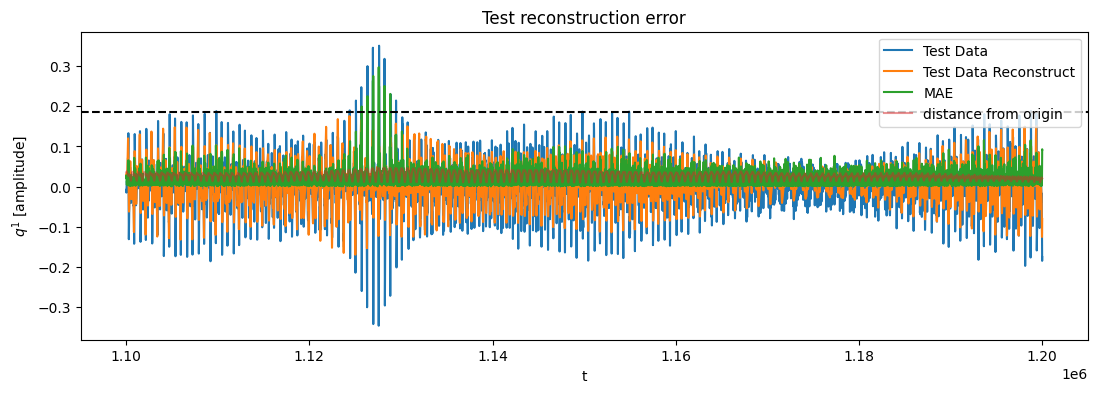

In [138]:
plt.figure(figsize=(13, 4))

limit = time_test_beta_2.shape

plt.plot(time_test_beta_2[:limit], X_test_beta2[:limit, 0, feature_idx],label='Test Data')
plt.plot(time_test_beta_2[:limit], X_test_beta_2_pred[:limit, 0, feature_idx],label='Test Data Reconstruct')
plt.plot(time_test_beta_2[:limit], test_mae_loss_beta2[:limit, feature_idx], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

plt.plot(time_test_beta_2[:limit], distances_test_beta_2[:limit] / 100, alpha=0.5, label='distance from origin')

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.title(f'Test reconstruction error')
plt.show()

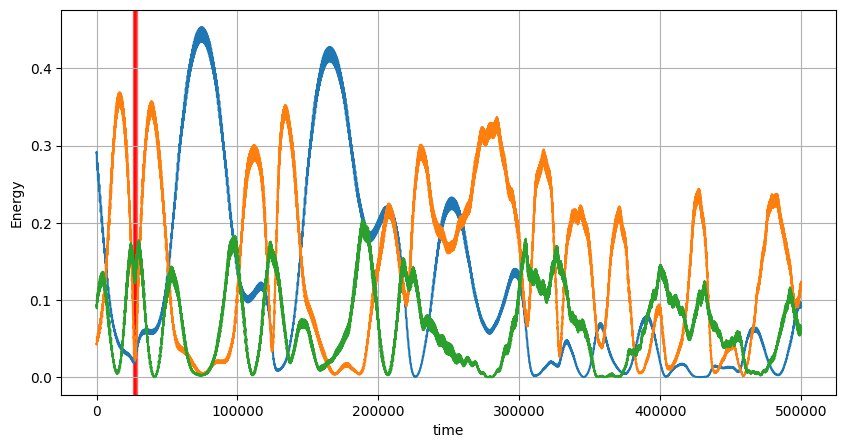

In [139]:
# find energy portion relative to above threshold reconstruction errror

times_above_threshold_beta2 = np.where(
    test_mae_loss_beta2[:limit, feature_idx] > max_thresholds_train)[0] + time_test_beta2[0]

ranges = find_ranges(times_above_threshold_beta2)

fig, (ax) = plt.subplots(1, 1, figsize=(10,5))
ax.plot(energy_test_beta2[:,0], linewidth=1.5, label="Mode 1") 
ax.plot(energy_test_beta2[:,2], linewidth=1.5, label="Mode 3")
ax.plot(energy_test_beta2[:,4], linewidth=1.5, label="Mode 5")
# ax.scatter(times_above_threshold_beta2, [0.0] * len(times_above_threshold_beta2), color='red') 

# ax.axvspan(1182784, 1182798, alpha=0.5, color='red')
for r in ranges:
    ax.axvspan(r[0], r[1], alpha=0.5, color='red')

ax.set_xlabel('time')
ax.set_ylabel('Energy')
ax.grid()

### Final remarks

It's essential to remember that while an autoencoder can provide valuable insights, it is a data-driven approach and may not provide a complete understanding of the underlying physics. However, it can aid in uncovering complex patterns and behaviors in the FPU system, especially related to energy transfer and mode-coupling.